# EB for KuaiRec

In [80]:
url <- "https://cran.r-project.org/src/contrib/Archive/NormalGamma/NormalGamma_1.1.tar.gz"
pkgFile <- "NormalGamma_1.1.tar.gz"
download.file(url = url, destfile = pkgFile)

In [ ]:
# please don't brick my R install


In [83]:
library(data.table)
library(tidyverse)
library(distr)
library(DescTools)
library(DirichletReg)
library(Rfast)

Warning message:
“package ‘Rfast’ was built under R version 4.1.2”
Loading required package: Rcpp

Loading required package: RcppZiggurat


Attaching package: ‘Rfast’


The following objects are masked from ‘package:DescTools’:

    Median, Rank, Sort, Var


The following object is masked from ‘package:distr’:

    Norm


The following object is masked from ‘package:dplyr’:

    nth


The following objects are masked from ‘package:purrr’:

    is_integer, transpose


The following object is masked from ‘package:data.table’:

    transpose




## Load, transform, plot data

run the following terminal commands to get the data:

```
 wget https://chongming.myds.me:61364/data/KuaiRec.zip --no-check-certificate
 unzip KuaiRec.zip
```

In [56]:
kuairec_raw = read.csv('KuaiRec 2.0/data/small_matrix.csv')

In [57]:
kuairec_raw$liked = as.integer(kuairec_raw$watch_ratio > 1.9)

count_df = count(kuairec_raw, video_id)
kuairec_raw <- merge(kuairec_raw, count_df, by='video_id')
avg_df = group_by(kuairec_raw, video_id) %>% summarize(avg_ratio = mean(watch_ratio), avg_likes = mean(liked))
kuairec_raw <- merge(kuairec_raw, avg_df, by='video_id')

In [65]:
head(kuairec_raw)

,video_id,user_id,play_duration,video_duration,time,date,timestamp,watch_ratio,liked,n,avg_ratio,avg_likes
,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,103,867,11070,10300,2020-07-19 02:11:00.18,20200719,1595095860,1.0747573,0,1410,0.7867078,0.02836879
2,103,4470,9815,10300,2020-07-19 15:34:19.58,20200719,1595144060,0.9529126,0,1410,0.7867078,0.02836879
3,103,2965,7090,10300,2020-07-09 12:33:38.853,20200709,1594269219,0.6883495,0,1410,0.7867078,0.02836879
4,103,1142,47902,10300,2020-07-15 12:37:29.061,20200715,1594787849,4.6506796,1,1410,0.7867078,0.02836879
5,103,2687,6700,10300,2020-07-13 07:36:25.778,20200713,1594596986,0.6504854,0,1410,0.7867078,0.02836879
6,103,4500,6080,10300,2020-07-18 15:56:21.356,20200718,1595058981,0.5902913,0,1410,0.7867078,0.02836879


In [58]:
in.train = sample(unique(avg_df$video_id), size = 0.6*length(unique(avg_df$video_id)))
kuairec_train = filter(avg_df, video_id %in% in.train)
kuairec_test = filter(avg_df, !video_id %in% in.train)

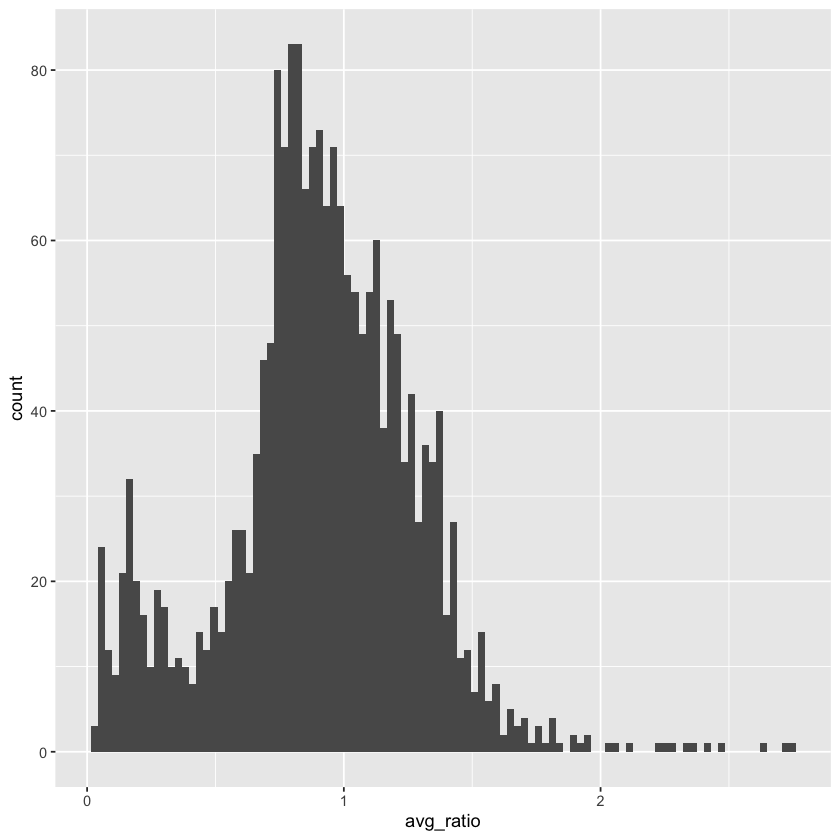

In [63]:
ggplot(kuairec_train) + geom_histogram(aes(x=avg_ratio), bins=100)

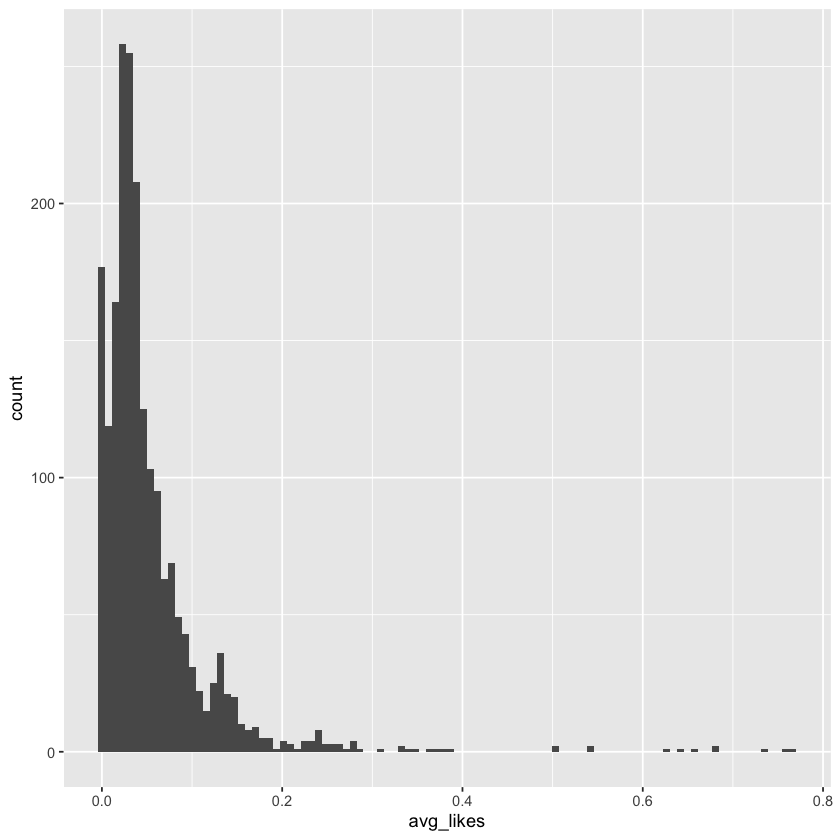

In [64]:
ggplot(kuairec_train) + geom_histogram(aes(x=avg_likes), bins=100)

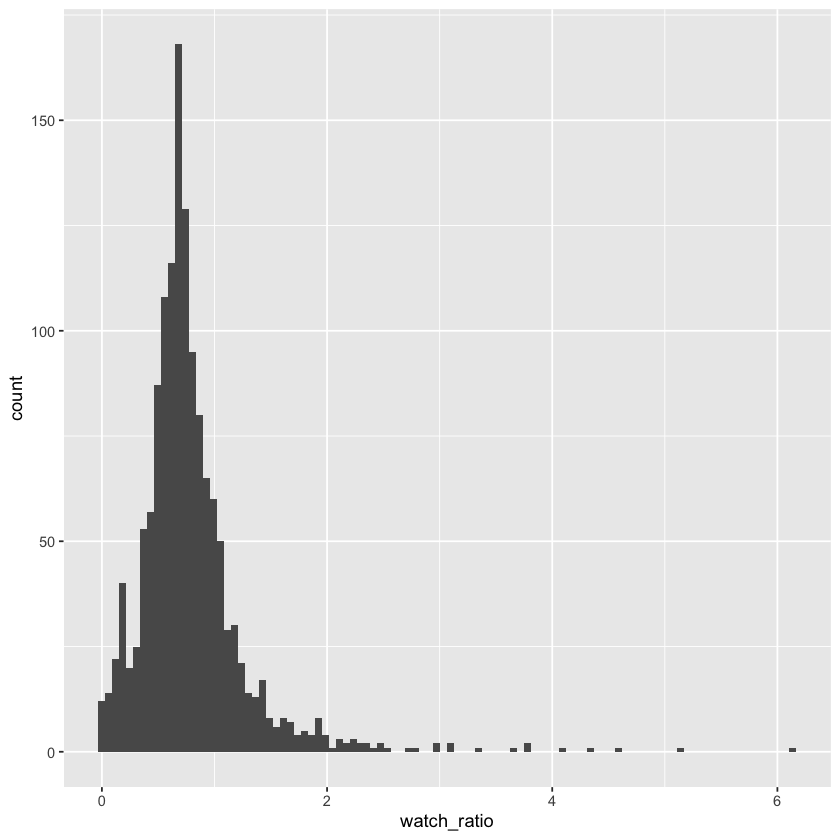

In [76]:
ggplot(kuairec_raw %>% filter(video_id == 237)) + geom_histogram(aes(x=watch_ratio), bins=100)

## Fit the prior hyperparameters

we assume, for watch ratio, a normal-gamma prior coupled with a normal likelihood, and for likes, a beta prior coupled with a Bernoulli likelihood.

### Likes

In [114]:
modified_likes = kuairec_train$avg_likes
modified_likes <- modified_likes[modified_likes > 0]
like_params = beta.mle(modified_likes, tol = 1e-9)$param

In [115]:
like_params

alpha      beta 
 0.977239 16.118707